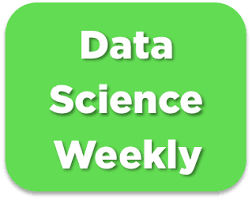

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.ensemble import BaggingClassifier

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# Read file with labels

In [2]:
data = pd.read_csv('/Users/qxzjy/vscworkspace/dsfs-ft-34/ml_module/project/data/conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [3]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


# Explore dataset

In [4]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000)

# Make your model

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

You can create new features by combining existing ones or transforming them to capture more meaningful relationships in the data. Here are some ideas:

1. **Interaction Features**:
    - Combine `age` and `total_pages_visited` (already done as `age_visited`).
    - Create a feature like `age * log_visited` to capture the interaction between age and logarithmic page visits.

2. **Engagement Ratio**:
    - Create a feature like `engagement_ratio = total_pages_visited / age` to measure how engaged users are relative to their age.

3. **Country-Based Features**:
    - Encode `country` into regions or group countries with similar conversion rates.

4. **Source-Based Features**:
    - Create a binary feature for whether the `source` is "Direct" or not, as direct traffic might have different conversion behavior.

5. **New User Interaction**:
    - Create a feature like `new_user_interaction = new_user * total_pages_visited` to capture how new users interact with the website.

6. **Logarithmic Transformations**:
    - Apply logarithmic transformations to other numerical features, such as `age`, to reduce skewness.

7. **Binned Features**:
    - Bin `age` into age groups (e.g., 18-25, 26-35, etc.) to capture non-linear relationships.

8. **Time-Based Features** (if available):
    - If you have timestamps, extract features like `hour`, `day_of_week`, or `is_weekend` to capture temporal patterns.

9. **Conversion Probability by Group**:
    - Calculate the average conversion rate for each `country`, `source`, or `age` group and use it as a feature.

10. **Custom Ratios**:
     - Create a feature like `log_visited_ratio = log_visited / total_pages_visited` to capture relative behavior.

You can experiment with these features and evaluate their impact on the f1-score.

In [ ]:
def bin_age(x):
    cat = ""
    if x < 26 :
        cat = "17_25"
    elif x < 35 :
        cat = "26_34"
    elif x < 44 :
        cat = "35_43"
    elif x < 52 :
        cat = "43_51"
    else :
        cat = "51_p"
    
data["log_visited"] = data["total_pages_visited"].apply(lambda x : np.log(x))
data["age_visited"] = data["age"]*data["total_pages_visited"]
data["engagement_ratio"] = data["total_pages_visited"]/data["age"]
data["new_user_interaction"] = data["total_pages_visited"]*data["new_user"]
data["age_bin"] = data["age"].apply(bin_age)

dict_features_id = {
    "country": 0,
    "age": 1,
    "new_user": 2,
    "source": 3,
    "total_pages_visited": 4,
    "age_visited":5,
    "log_visited":6,
    "engagement_ratio":7,
    "new_user_interaction":8,
    "age_bin":9
}

numerical_features_list = ["age", "total_pages_visited", "age_visited", "log_visited", "engagement_ratio", "new_user_interaction", "age_bin"]
categorical_features_list = ["country", "new_user", "source"]

In [6]:
data["age"].value_counts()

age
28     12972
30     12956
29     12710
27     12668
26     12525
31     12327
25     12157
32     12111
24     11647
33     11392
23     11097
34     10911
22     10471
35     10352
21      9870
36      9668
20      9131
37      8773
19      8452
38      8067
18      7662
39      7343
17      6825
40      6451
41      5783
42      5029
43      4423
44      3808
45      3249
46      2693
47      2255
48      1898
49      1467
50      1213
51       990
52       835
53       571
54       459
55       352
56       251
57       211
58       147
59       115
60        86
61        63
62        50
63        29
64        26
65        14
66         9
67         5
68         2
70         2
111        1
72         1
69         1
73         1
79         1
123        1
77         1
Name: count, dtype: int64

In [ ]:
features_selected = ["country", "age", "new_user", "total_pages_visited", "age_visited", "log_visited", "engagement_ratio", "new_user_interaction", "age_bin"]
target_variable = "converted"

X = data.loc[:, features_selected]
Y = data[target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['country', 'age', 'new_user', 'total_pages_visited', 'age_visited',
       'log_visited', 'engagement_ratio', 'new_user_interaction'],
      dtype='object')



In [8]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



## Training pipeline

In [9]:
numerical_features = []
categorical_features = []

for i in features_selected :
    if i in numerical_features_list :
        numerical_features.append(i)
    else :
        categorical_features.append(i)

In [10]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")
numerical_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(drop="first")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

X_train = preprocessor.fit_transform(X_train)
print("...Done")
print(X_train[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.91516278 -0.26070136 -0.51612832  0.06002617  0.00628742 -0.96316986
   0.          0.          0.          0.        ]
 [-0.67320988  0.93728655  0.48667253  1.010788    1.06846176  1.43606463
   0.          0.          1.          1.        ]
 [ 0.17362526 -0.85969532 -0.77611373 -0.89073566 -0.80377857 -0.36336124
   0.          0.          1.          1.        ]
 [ 0.7785075  -0.56019834 -0.33970965 -0.33457564 -0.66867857 -0.06345692
   0.          0.          1.          1.        ]
 [-0.79418633 -0.26070136 -0.47898755  0.06002617 -0.0463998   0.23644739
   0.          1.          0.          1.        ]]


In [11]:
# Train model
print("Train model...")
lr = LogisticRegression()
model = BaggingClassifier(estimator=lr)

params = {
    "estimator__C": [0.3, 0.5, 0.7, 0.9],
    "n_estimators": [10, 20, 30]
}

classifier = GridSearchCV(model, param_grid=params, cv=3)
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [12]:
classifier.best_params_

{'estimator__C': 0.7, 'n_estimators': 10}

In [13]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



## Test pipeline

In [14]:
# Use X_test, and the same preprocessings as in training pipeline, 
# but call "transform()" instead of "fit_transform" methods (see example below)

print("Encoding categorical features and standardizing numerical features...")

X_test = preprocessor.transform(X_test)
print("...Done")
print(X_test[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-1.27809213  0.63778957 -0.07043905  0.82762841  1.28658684  1.13616032
   0.          0.          1.          1.        ]
 [ 0.05264881  0.03879562  0.06883884  0.36610311 -0.08549031  0.5363517
   0.          0.          1.          1.        ]
 [-0.31028053 -0.26070136 -0.33042446  0.06002617 -0.21951494 -0.96316986
   0.          0.          1.          0.        ]
 [-0.67320988 -0.26070136 -0.44184678  0.06002617 -0.09487204  0.23644739
   1.          0.          0.          1.        ]
 [ 1.62534265  0.63778957  1.48947339  0.82762841 -0.10148189 -0.96316986
   0.          0.          1.          0.        ]]


In [15]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



## Performance assessment

In [16]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7620009425705244
f1-score on test set :  0.7566938300349243


In [17]:
A =

SyntaxError: invalid syntax (12477046.py, line 1)

In [ ]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[233362  14537]
 [   512   7711]]

Confusion matrix on test set : 
[[25894  1607]
 [   55   902]]



**Our baseline model reaches a f1-score of almost 70%. Now, feel free to refine your model and try to beat this score ! 🚀🚀**

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [ ]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier.fit(X,Y)

RFE(estimator=LogisticRegression(class_weight='balanced'),
    n_features_to_select=7)

In [ ]:
# Read data without labels
data_without_labels = pd.read_csv('/Users/qxzjy/vscworkspace/dsfs-ft-34/ml_module/project/data/conversion_data_test.csv')
data_without_labels["age_visited"] = data_without_labels["age"]*data_without_labels["total_pages_visited"]
data_without_labels["log_visited"] = data_without_labels["total_pages_visited"].apply(lambda x : np.log(x))

print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
X_without_labels = data_without_labels.loc[:, features_selected]

# Convert pandas DataFrames to arrays before using scikit-learn
print("Convert pandas DataFrames to arrays...")
#X_without_labels = X_without_labels.values
print("...Done")

#print(X_without_labels[0:5,:])

Prediction set (without labels) : (31620, 7)
Convert pandas DataFrames to arrays...
...Done


In [ ]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels

X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

...Done
[[-0.31028053  3.33326238  2.78940043  1.96154982  0.          1.
   0.          0.        ]
 [-1.03613923  0.03879562 -0.34899485  0.36610311  0.          1.
   0.          1.        ]
 [ 0.17362526 -1.15919229 -1.07323991 -1.84149748  0.          0.
   0.          1.        ]
 [ 0.17362526  0.3382926   0.41239099  0.61618619  0.          0.
   1.          1.        ]
 [-0.67320988 -0.56019834 -0.6739766  -0.33457564  0.          0.
   0.          0.        ]]


In [ ]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('/Users/qxzjy/vscworkspace/dsfs-ft-34/ml_module/project/conversion_rate_challenche/predictions/conversion_data_test_predictions_MAXIME-model-1.csv', index=False)


## Analyzing the coefficients and interpreting the result
**In this template, we just trained a model with only one feature (total_pages_visited), so there's no analysis to be done about the feature importance 🤔**

**Once you've included more features in your model, please take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**